#Voting

Intersection-based Voting

---



---




1.   Applica SAM su ciascun input: Ottieni 3 set di maschere: M_RGB, M_ExG, M_TGI
2.   Filtra le maschere in ogni set: area, roundness, stability score, eccentricità...
3. Allinea e confronta le maschere tra gli input : Usa IoU per confrontare le maschere tra RGB/ExG/TGI. Se una maschera di M_RGB ha IoU > soglia con maschere sia in M_ExG che M_TGI, aumenta il voting_score.
4. Seleziona le maschere con voting_score >= threshold, Maschere confermate da più input = più robuste.



---



---



In [ ]:
# Pseudocodice per selezionare le maschere "ottimali" dopo l'applicazione dei filtri
for mask_rgb in masks_RGB:
    score = 0
    for mask_exg in masks_ExG:
      if mask_rgb['bbox'] = mask_exg['bbox']:
        if iou(mask_rgb, mask_exg) > 0.5:
            score += 0.8  # peso per ExG
    for mask_tgi in masks_TGI:
      if mask_rgb['bbox'] = mask_tgi['bbox']:
        if iou(mask_rgb, mask_tgi) > 0.5:
            score += 0.7  # peso per TGI
    if score >= 1.3:
        keep_mask(mask_rgb)



---



---



#Load Raw Images

In [ ]:
import cv2
exg_image = cv2.imread('/content/201812_cropped_exg_normalized.png')
exg_image = cv2.cvtColor(exg_image, cv2.COLOR_BGR2RGB)

real_image = cv2.imread('/content/201812_cropped.png')
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

# Ridimensionare l'immagine
def resize_image(image):
    scale_percent = 20
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    return resized_image

exg_image_resized = resize_image(exg_image)
real_image_resized = resize_image(real_image)

#Load pkl

In [ ]:
# Caricamento pkl

import pickle
with open('/content/masks_sam_filtered.pkl', 'rb') as f:
    real_masks = pickle.load(f)

with open('/content/masks_exg_filtered.pkl', 'rb') as f:
    exg_masks = pickle.load(f)

print(f"Real Masks Loaded: {len(real_masks)}")
print(f"Band Masks Loaded: {len(exg_masks)}")

Real Masks Loaded: 39
Band Masks Loaded: 61


In [ ]:
# controllo che i dizionari abbiano la stessa struttura

print(real_masks[0].keys())
print(exg_masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box', 'id', 'real_area', 'roundness', 'eccentricity'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box', 'id', 'real_area', 'roundness', 'eccentricity'])


#Merged Masks Visualisation

In [ ]:
import numpy as np
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) #ordina le maschere per ordine di area
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4)) #crea immagine RGBA trasparente
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]]) #colore casuale per ogni maschera più trasparenza
        img[m] = color_mask
    ax.imshow(img)

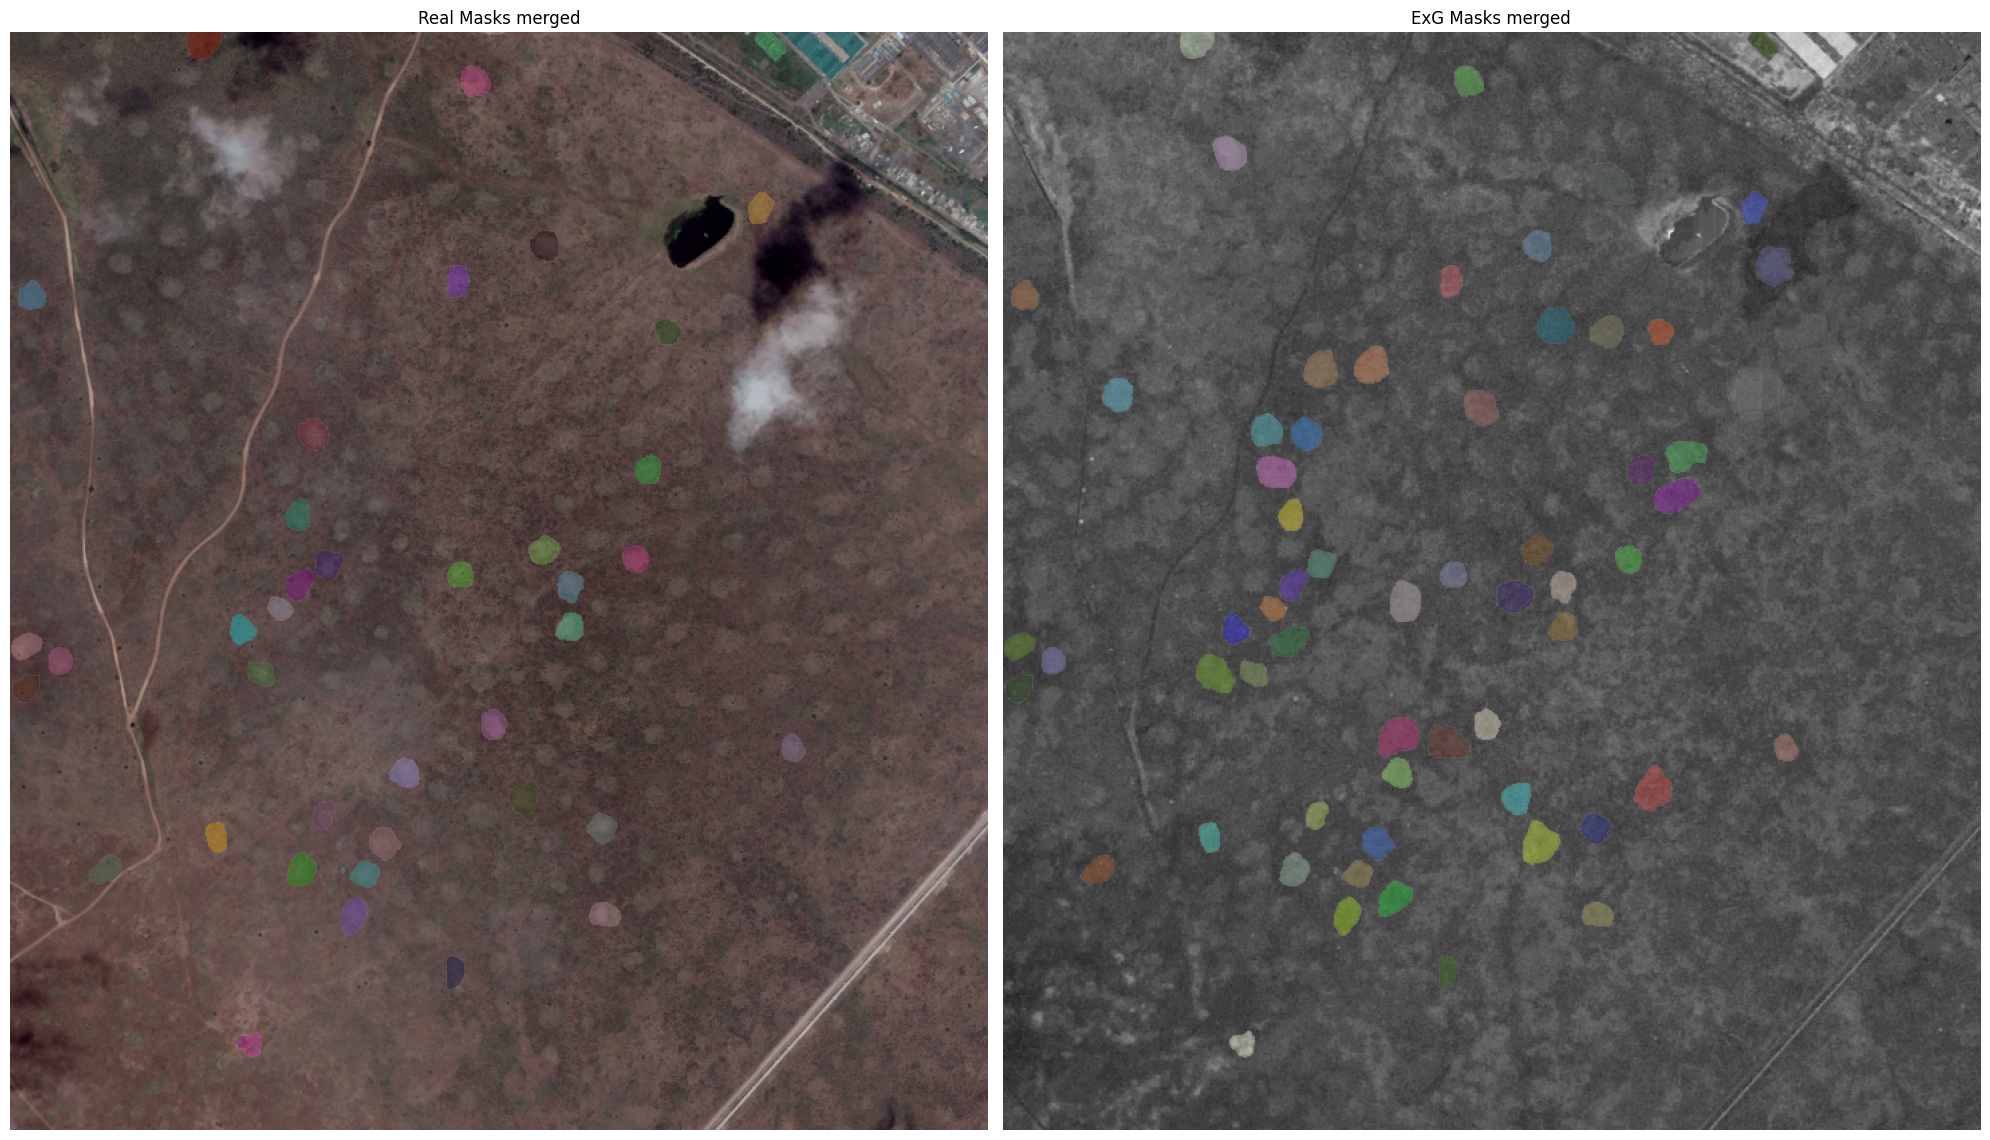

In [ ]:
# Visualizzazione affiancata
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

# SINISTRA: Real Image
plt.sca(axs[0])
axs[0].imshow(real_image_resized)
show_anns(real_masks)
axs[0].axis('off')
axs[0].set_title("Real Masks merged")

# DESTRA: Band image
plt.sca(axs[1])
axs[1].imshow(exg_image_resized)
show_anns(exg_masks)
axs[1].axis('off')
axs[1].set_title("ExG Masks merged")

plt.tight_layout()
plt.show()

In [ ]:
print(type(real_masks))
print(type(real_masks[0]))
print(real_masks[0].keys())

<class 'list'>
<class 'dict'>
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box', 'id', 'real_area', 'roundness', 'eccentricity'])


In [ ]:
# iou = 1.0 le maschere sono identiche, iou = 0.5 sovrapposizione parziale, iou = 0.0 nessuna sovrapposizione
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    else:
        return intersection / union

def match_masks(masks_rgb, masks_exg, area_tolerance=0.3):
    matches = []

    for i, mask_rgb in enumerate(masks_rgb):
        area_rgb = mask_rgb['area']
        bin_rgb = mask_rgb['segmentation']

        for j, mask_exg in enumerate(masks_exg):
            area_exg = mask_exg['area']
            bin_exg = mask_exg['segmentation']

            # Check area similarity
            #relative_diff = abs(area_rgb - area_exg) / max(area_rgb, area_exg)
            #if relative_diff > area_tolerance:
                #continue  # troppo diverse in scala, skip

            # Compute IoU
            score = iou(bin_rgb, bin_exg)
            #print(f"mask_rgb= {mask_rgb['id']} i={i} - mask_exg= {mask_exg['id']} j={j} - score={score}")
            matches.append((mask_rgb, score))

    return matches

In [ ]:
matches = match_masks(real_masks, exg_masks, area_tolerance=0.3)
print(f"Computed {len(matches)} matches")

Computed 2379 matches


In [ ]:
def filter_matches_by_score(matches, threshold=0.5):
    """
    Filtra una lista di match (i, j, score) mantenendo solo quelli con score >= threshold.

    Args:
        matches (list of tuples): lista di tuple (i, j, score)
        threshold (float): soglia di filtro per lo score (es. IoU)

    Returns:
        list of tuples: match filtrati
    """
    return [mask for mask, score in matches if score >= threshold]

SyntaxError: invalid syntax (<ipython-input-102-47e05a38e95f>, line 12)

In [ ]:
# Filtriamo con soglia 0.6
filtered_matches = filter_matches_by_score(matches, threshold=0.6)

print(len(filtered_matches))

39


In [ ]:
print(type(filtered_matches))

<class 'list'>


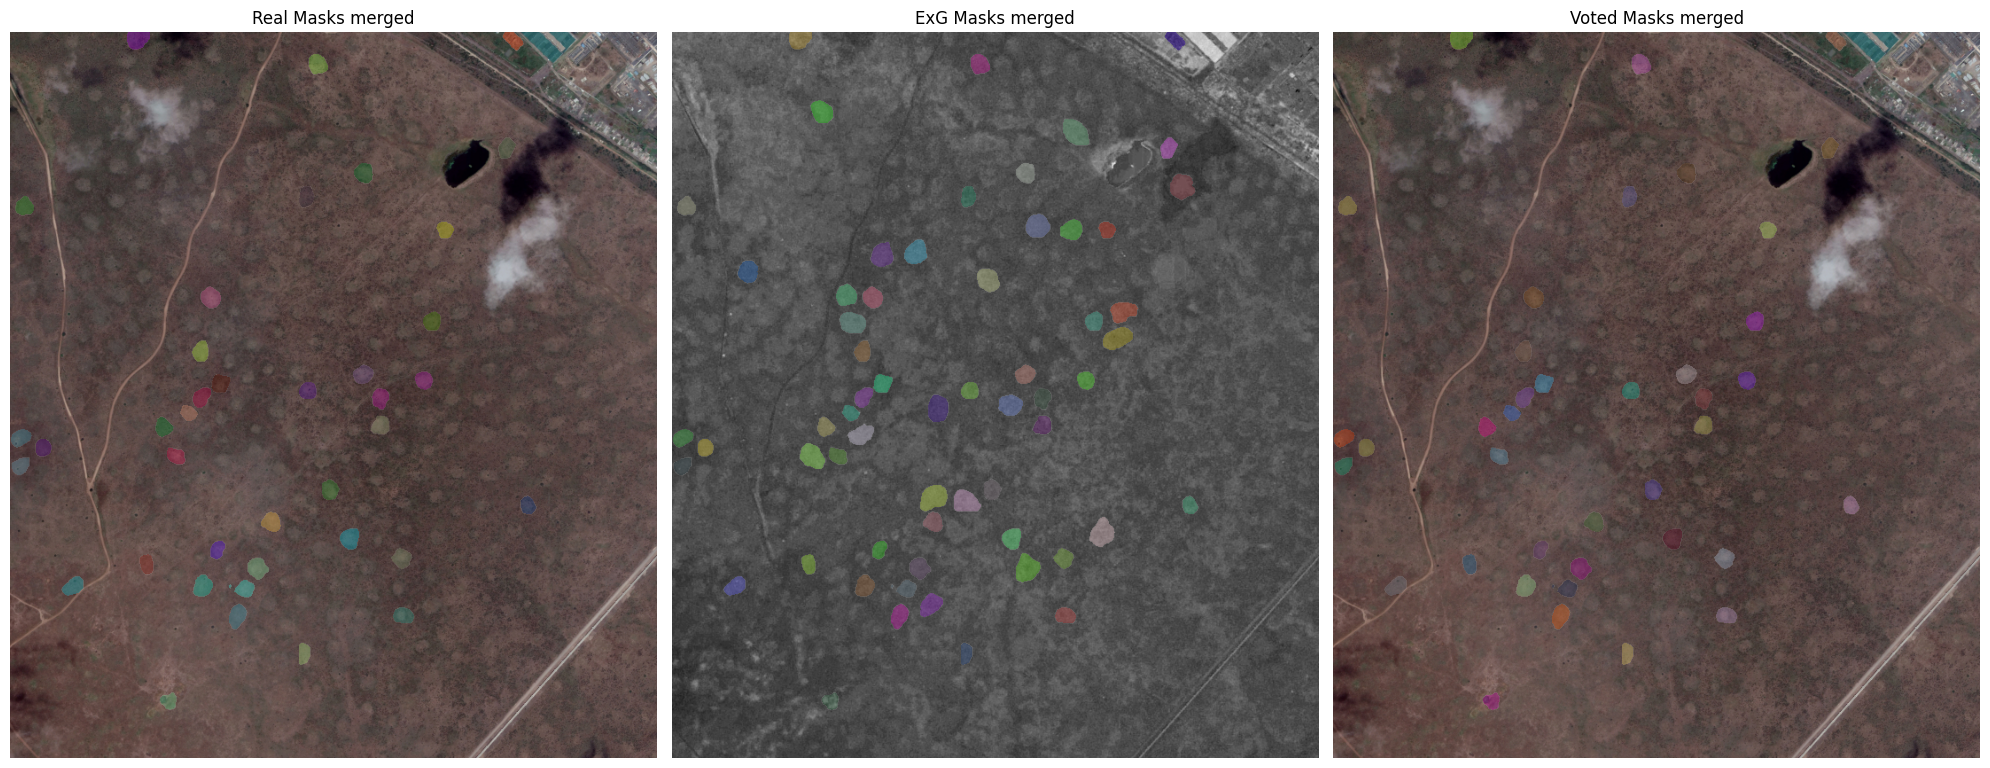

In [ ]:
# Visualizzazione affiancata
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

# SINISTRA: Real Image
plt.sca(axs[0])
axs[0].imshow(real_image_resized)
show_anns(real_masks)
axs[0].axis('off')
axs[0].set_title("Real Masks merged")

# Centro: Band image
plt.sca(axs[1])
axs[1].imshow(exg_image_resized)
show_anns(exg_masks)
axs[1].axis('off')
axs[1].set_title("ExG Masks merged")

# DESTRA: Voted image
plt.sca(axs[2])
axs[2].imshow(real_image_resized)
show_anns(filtered_matches)
axs[2].axis('off')
axs[2].set_title("Voted Masks merged")

plt.tight_layout()
plt.show()